# CYBERML - Project

## Importation du dataset

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# file1_path = "../SWaT.A7_June 2020/22June2020 (1).xlsx"
# file2_path = "../SWaT.A7_June 2020/22June2020 (2).xlsx"
# file3_path = "../SWaT.A7_June 2020/29June2020 (1).xlsx"
# file4_path = "../SWaT.A7_June 2020/29June2020 (2).xlsx"

# df1 = pd.read_excel(file1_path)
# df2 = pd.read_excel(file2_path)
# df3 = pd.read_excel(file3_path, usecols=range(61))
# df4 = pd.read_excel(file4_path)
# print(df1.shape)
# print(df2.shape)
# print(df3.shape)
# print(df4.shape)

In [3]:
# print(df1.columns.to_list())
# print(df2.columns.to_list())
# print(df3.columns.to_list())
# print(df4.columns.to_list())

In [4]:
# common_columns = list(set(df1.columns) & set(df2.columns) & set(df3.columns) & set(df4.columns))
# # columns in df1 but not in common_columns
# missing_columns = list(set(df1.columns) - set(common_columns))
# print(missing_columns)
# print(len(missing_columns))
# print(len(common_columns))

# print(f"Missing columns : {list(set(df1.columns) ^ set(df2.columns) ^ set(df3.columns) ^ set(df4.columns))}")

In [5]:
# df1 = df1[common_columns]
# df2 = df2[common_columns]
# df3 = df3[common_columns]
# df4 = df4[common_columns]
# print(df1.columns.to_list())
# print(df2.columns.to_list())
# print(df3.columns.to_list())
# print(df4.columns.to_list())

In [6]:
# if list(df1.columns) != list(df2.columns) or list(df1.columns) != list(df3.columns) or list(df1.columns) != list(df4.columns):
#     print("Les colonnes des deux fichiers ne correspondent pas.")
#     print("Colonnes dans le fichier 1 :", df1.columns)
#     print("Colonnes dans le fichier 2 :", df2.columns)
#     print("Colonnes dans le fichier 3 :", df3.columns)
#     print("Colonnes dans le fichier 4 :", df4.columns)
# else:
#     print("Les colonnes des deux fichiers correspondent.")
#     df_combined = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

#     # Vérifier le nombre de lignes et de colonnes du dataset combiné
#     print(f"Dataset combiné : {df_combined.shape} lignes et colonnes")

#     # Sauvegarder le dataset combiné dans un fichier CSV
#     output_path = "../SWaT.A7_June 2020/df_combined.csv"
#     df_combined.to_csv(output_path, index=False)

#     print(f"Dataset fusionné sauvegardé dans : {output_path}")

In [7]:
df = pd.read_csv("../SWaT.A7_June 2020/df_combined.csv", low_memory=False)

In [8]:
df.shape

(32402, 61)

In [9]:
df.tail()

,MV101.Status,P302.Status,FIT501.Pv,P204.Status,PIT503.Pv,MV303.Status,P101.Status,P205.Status,AIT202.Pv,PIT502.Pv,...,FIT601.Pv,P403.Status,MV501.Status,FIT401.Pv,P601.Status,AIT503.Pv,MV502.Status,MV504.Status,P5_STATE,AIT201.Pv
32397,1,1,1.34324539,1,202.656372,1,2,2,8.310562,2.14654136,...,0.000320379331,1,2,1.33376014,1,31.498333,2,1,12,34.2540359
32398,1,1,1.34478343,1,202.656372,1,2,2,8.307037,2.14654136,...,0.000320379331,1,2,1.33299184,1,31.498333,2,1,12,34.2540359
32399,1,1,1.34632146,1,202.656372,1,2,2,8.303833,2.14654136,...,0.000320379331,1,2,1.33299184,1,31.6905918,2,1,12,34.2540359
32400,1,1,1.34632146,1,202.656372,1,2,2,8.30191,2.14654136,...,0.000320379331,1,2,1.33299184,1,31.6905918,2,1,12,34.2540359
32401,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,...,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input


In [10]:
df = df.drop(df.tail(1).index)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MV101.Status  32401 non-null  object
 1   P302.Status   32401 non-null  object
 2   FIT501.Pv     32401 non-null  object
 3   P204.Status   32401 non-null  object
 4   PIT503.Pv     32401 non-null  object
 5   MV303.Status  32401 non-null  object
 6   P101.Status   32401 non-null  object
 7   P205.Status   32401 non-null  object
 8   AIT202.Pv     32401 non-null  object
 9   PIT502.Pv     32401 non-null  object
 10  P402.Status   32401 non-null  object
 11  AIT402.Pv     32401 non-null  object
 12  P502.Status   32401 non-null  object
 13  FIT301.Pv     32401 non-null  object
 14  AIT504.Pv     32401 non-null  object
 15  MV201.Status  32401 non-null  object
 16  FIT502.Pv     32401 non-null  object
 17  AIT401.Pv     32401 non-null  object
 18  FIT201.Pv     32401 non-null  object
 19  PIT5

In [12]:
df.describe()

,MV101.Status,P302.Status,FIT501.Pv,P204.Status,PIT503.Pv,MV303.Status,P101.Status,P205.Status,AIT202.Pv,PIT502.Pv,...,FIT601.Pv,P403.Status,MV501.Status,FIT401.Pv,P601.Status,AIT503.Pv,MV502.Status,MV504.Status,P5_STATE,AIT201.Pv
count,32401,32401,32401,32401,32401,32401,32401,32401,32401,32401,...,32401,32401,32401,32401,32401,32401,32401,32401,32401,32401
unique,3,1,723,1,781,3,2,2,5838,213,...,169,1,3,688,2,613,3,3,17,1817
top,1,1,0.00230710068999999,1,7.8345294,1,1,1,9.640348,2.05042768,...,0.000256303465,1,2,0.000512196699999999,1,46.91105,2,1,12,18.0722885
freq,29725,32401,4657,32401,938,31955,17350,17725,49,4056,...,23697,32401,24192,9074,25873,3673,24092,31745,24016,3802


In [13]:
df.isnull().sum()

MV101.Status    0
P302.Status     0
FIT501.Pv       0
P204.Status     0
PIT503.Pv       0
               ..
AIT503.Pv       0
MV502.Status    0
MV504.Status    0
P5_STATE        0
AIT201.Pv       0
Length: 61, dtype: int64

In [14]:
pd.set_option('display.max_columns', None)
df.columns

Index(['MV101.Status', 'P302.Status', 'FIT501.Pv', 'P204.Status', 'PIT503.Pv',
       'MV303.Status', 'P101.Status', 'P205.Status', 'AIT202.Pv', 'PIT502.Pv',
       'P402.Status', 'AIT402.Pv', 'P502.Status', 'FIT301.Pv', 'AIT504.Pv',
       'MV201.Status', 'FIT502.Pv', 'AIT401.Pv', 'FIT201.Pv', 'PIT501.Pv',
       'MV503.Status', 'MV302.Status', 'P301.Status', 'LIT401.Pv', 'LIT101.Pv',
       'P202.Status', 'LIT301.Pv', 'FIT504.Pv', 'AIT502.Pv', 'P2_STATE',
       'DPIT301.Pv', 'P1_STATE', 't_stamp', 'MV301.Status', 'P401.Status',
       'P3_STATE', 'P206.Status', 'MV304.Status', 'P201.Status',
       'UV401.Status', 'P602.Status', 'AIT501.Pv', 'FIT101.Pv', 'P203.Status',
       'P4_STATE', 'P501.Status', 'P6_STATE', 'AIT203.Pv', 'P102.Status',
       'P404.Status', 'FIT503.Pv', 'FIT601.Pv', 'P403.Status', 'MV501.Status',
       'FIT401.Pv', 'P601.Status', 'AIT503.Pv', 'MV502.Status', 'MV504.Status',
       'P5_STATE', 'AIT201.Pv'],
      dtype='object')

### Pré-traitement des données

In [15]:
df = df.dropna()
df.isnull().sum()

MV101.Status    0
P302.Status     0
FIT501.Pv       0
P204.Status     0
PIT503.Pv       0
               ..
AIT503.Pv       0
MV502.Status    0
MV504.Status    0
P5_STATE        0
AIT201.Pv       0
Length: 61, dtype: int64

In [16]:
columns_to_encode = [column for column in df.columns if df[column].nunique() < 20]
print(columns_to_encode)
print(len(columns_to_encode))

['MV101.Status', 'P302.Status', 'P204.Status', 'MV303.Status', 'P101.Status', 'P205.Status', 'P402.Status', 'AIT402.Pv', 'P502.Status', 'MV201.Status', 'AIT401.Pv', 'MV503.Status', 'MV302.Status', 'P301.Status', 'P202.Status', 'FIT504.Pv', 'P2_STATE', 'P1_STATE', 'MV301.Status', 'P401.Status', 'P3_STATE', 'P206.Status', 'MV304.Status', 'P201.Status', 'UV401.Status', 'P602.Status', 'P203.Status', 'P4_STATE', 'P501.Status', 'P6_STATE', 'P102.Status', 'P404.Status', 'P403.Status', 'MV501.Status', 'P601.Status', 'MV502.Status', 'MV504.Status', 'P5_STATE']
38


In [17]:
df = pd.get_dummies(df, drop_first=True, columns=columns_to_encode)

In [18]:
df['t_stamp'] = pd.to_datetime(df['t_stamp'], format='mixed')
df_22 = df[df['t_stamp'].dt.day == 22]
df_29 = df[df['t_stamp'].dt.day == 29]
start_time_29 = df_29['t_stamp'].min()
end_time_29 = df_29['t_stamp'].max()
start_time_22 = df_22['t_stamp'].min()
end_time_22 = df_22['t_stamp'].max()
print(f"22nd of June started at : {start_time_22} and ended at : {end_time_22}")
print(f"29th of June started at : {start_time_29} and ended at : {end_time_29}")

22nd of June started at : 2020-06-22 09:00:00 and ended at : 2020-06-22 14:01:10.990000
29th of June started at : 2020-06-29 10:00:00 and ended at : 2020-06-29 15:29:59


In [19]:
df_22.set_index('t_stamp', inplace=True)
df_29.set_index('t_stamp', inplace=True)

In [20]:
scaler = StandardScaler()
df_22_scaled = scaler.fit_transform(df_22)
df_22_scaled = pd.DataFrame(df_22_scaled, columns=df_22.columns)
df_29_scaled = scaler.fit_transform(df_29)
df_29_scaled = pd.DataFrame(df_29_scaled, columns=df_29.columns)
df_scaled = pd.concat([df_22_scaled, df_29_scaled], axis=0)
df_scaled.head()

,FIT501.Pv,PIT503.Pv,AIT202.Pv,PIT502.Pv,FIT301.Pv,AIT504.Pv,FIT502.Pv,FIT201.Pv,PIT501.Pv,LIT401.Pv,LIT101.Pv,LIT301.Pv,AIT502.Pv,DPIT301.Pv,AIT501.Pv,FIT101.Pv,AIT203.Pv,FIT503.Pv,FIT601.Pv,FIT401.Pv,AIT503.Pv,AIT201.Pv,MV101.Status_1,MV101.Status_2,MV303.Status_1,MV303.Status_2,P101.Status_2,P205.Status_2,MV201.Status_1,MV201.Status_2,MV503.Status_1,MV503.Status_2,MV302.Status_1,MV302.Status_2,P301.Status_2,FIT504.Pv_0.0,FIT504.Pv_6.405534e-05,P2_STATE_2,P1_STATE_2,P1_STATE_3,MV301.Status_1,MV301.Status_2,P401.Status_2,P3_STATE_10,P3_STATE_12,P3_STATE_13,P3_STATE_14,P3_STATE_15,P3_STATE_16,P3_STATE_2,P3_STATE_4,P3_STATE_5,P3_STATE_6,P3_STATE_7,P3_STATE_9,P3_STATE_99,MV304.Status_1,MV304.Status_2,P201.Status_2,UV401.Status_2,P602.Status_2,P203.Status_2,P4_STATE_2,P4_STATE_3,P4_STATE_4,P501.Status_2,P6_STATE_2,MV501.Status_1,MV501.Status_2,P601.Status_2,MV502.Status_1,MV502.Status_2,MV504.Status_1,MV504.Status_2,P5_STATE_10,P5_STATE_11,P5_STATE_12,P5_STATE_13,P5_STATE_15,P5_STATE_16,P5_STATE_17,P5_STATE_18,P5_STATE_19,P5_STATE_21,P5_STATE_3,P5_STATE_4,P5_STATE_5,P5_STATE_6,P5_STATE_8,P5_STATE_9
0,0.680738,0.706508,-0.755583,0.024663,-1.053379,-0.107304,0.710634,-0.806364,0.70593,-0.400634,-0.382391,0.967036,-0.783706,-1.022033,0.332407,-0.217778,0.155874,0.704228,-0.077618,0.683918,-0.396841,-0.749154,0.218192,-0.215948,0.13771,-0.129303,-0.804828,-0.799777,0.813004,-0.805578,0.155693,-0.144268,1.021112,-1.010387,-1.041296,0.0,0.0,0.150948,-1.847682,1.973313,0.089172,-0.074367,0.69811,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.433998,0.176533,-0.157184,-0.799777,0.699166,-0.072066,-0.799777,-0.023577,-0.01826,0.12774,0.71934,0.150948,-0.520583,0.522996,-0.482048,-0.527043,0.529881,0.169205,-0.159946,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352
1,0.680738,0.706508,-0.761180,0.024663,-1.053379,-0.107304,0.712522,-0.806364,0.70593,-0.401956,-0.384191,0.967036,-0.783706,-1.022033,0.299725,-0.217778,0.155874,0.704228,-0.077618,0.683918,-0.396841,-0.748193,0.218192,-0.215948,0.13771,-0.129303,-0.804828,-0.799777,0.813004,-0.805578,0.155693,-0.144268,1.021112,-1.010387,-1.041296,0.0,0.0,0.150948,-1.847682,1.973313,0.089172,-0.074367,0.69811,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.433998,0.176533,-0.157184,-0.799777,0.699166,-0.072066,-0.799777,-0.023577,-0.01826,0.12774,0.71934,0.150948,-0.520583,0.522996,-0.482048,-0.527043,0.529881,0.169205,-0.159946,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352
2,0.680738,0.706508,-0.767895,0.024663,-1.053379,-0.107304,0.712522,-0.806364,0.70593,-0.402544,-0.386441,0.967036,-0.783706,-1.022033,0.299725,-0.217778,0.155874,0.704228,-0.077618,0.683918,-0.396841,-0.748193,0.218192,-0.215948,0.13771,-0.129303,-0.804828,-0.799777,0.813004,-0.805578,0.155693,-0.144268,1.021112,-1.010387,-1.041296,0.0,0.0,0.150948,-1.847682,1.973313,0.089172,-0.074367,0.69811,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.433998,0.176533,-0.157184,-0.799777,0.699166,-0.072066,-0.799777,-0.023577,-0.01826,0.12774,0.71934,0.150948,-0.520583,0.522996,-0.482048,-0.527043,0.529881,0.169205,-0.159946,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352
3,0.680738,0.706508,-0.772746,0.024663,-1.053379,-0.107304,0.724318,-0.806364,0.70593,-0.402838,-0.386441,0.967036,-0.789460,-1.022033,0.299725,-0.217778,0.155874,0.704228,-0.077618,0.683918,-0.396841,-0.748193,0.218192,-0.215948,0.13771,-0.129303,-0.804828,-0.799777,0.813004,-0.805578,0.155693,-0.144268,1.021112,-1.010387,

## option 1 : Anomaly Detection

### Isolation Forest

In [ ]:
contamination = 0.02
duration = end_time_29 - start_time_29
print(f"We expect to be attacked for a duration of about {(contamination * duration).seconds} seconds")

model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)

model.fit(df_22_scaled)
df_29.loc[:, "Anomalie"] = model.predict(df_29_scaled)
df_22.loc[:, "Anomalie"] = 1

df_if = pd.concat([df_22, df_29], axis=0)
df_if.head()

We expect to be attacked for a duration of about 395 seconds


/tmp/ipykernel_191122/3848145625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_29.loc[:, "Anomalie"] = model.predict(df_29_scaled)
/tmp/ipykernel_191122/3848145625.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22.loc[:, "Anomalie"] = 1


,FIT501.Pv,PIT503.Pv,AIT202.Pv,PIT502.Pv,FIT301.Pv,AIT504.Pv,FIT502.Pv,FIT201.Pv,PIT501.Pv,LIT401.Pv,LIT101.Pv,LIT301.Pv,AIT502.Pv,DPIT301.Pv,AIT501.Pv,FIT101.Pv,AIT203.Pv,FIT503.Pv,FIT601.Pv,FIT401.Pv,AIT503.Pv,AIT201.Pv,MV101.Status_1,MV101.Status_2,MV303.Status_1,MV303.Status_2,P101.Status_2,P205.Status_2,MV201.Status_1,MV201.Status_2,MV503.Status_1,MV503.Status_2,MV302.Status_1,MV302.Status_2,P301.Status_2,FIT504.Pv_0.0,FIT504.Pv_6.405534e-05,P2_STATE_2,P1_STATE_2,P1_STATE_3,MV301.Status_1,MV301.Status_2,P401.Status_2,P3_STATE_10,P3_STATE_12,P3_STATE_13,P3_STATE_14,P3_STATE_15,P3_STATE_16,P3_STATE_2,P3_STATE_4,P3_STATE_5,P3_STATE_6,P3_STATE_7,P3_STATE_9,P3_STATE_99,MV304.Status_1,MV304.Status_2,P201.Status_2,UV401.Status_2,P602.Status_2,P203.Status_2,P4_STATE_2,P4_STATE_3,P4_STATE_4,P501.Status_2,P6_STATE_2,MV501.Status_1,MV501.Status_2,P601.Status_2,MV502.Status_1,MV502.Status_2,MV504.Status_1,MV504.Status_2,P5_STATE_10,P5_STATE_11,P5_STATE_12,P5_STATE_13,P5_STATE_15,P5_STATE_16,P5_STATE_17,P5_STATE_18,P5_STATE_19,P5_STATE_21,P5_STATE_3,P5_STATE_4,P5_STATE_5,P5_STATE_6,P5_STATE_8,P5_STATE_9,Anomalie
t_stamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-22 10:00:00.000,1.29928231,206.9982,7.51941824,2.0183897,0.0006405534,1.84568059,1.1651082,0.000256303465,232.376312,632.1841,695.2841,1006.75311,149.6283,3.44132137,7.61554766,0.0,135.708786,0.116122015,0.000256303465,1.29419291,46.91105,18.0722885,True,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,True,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2020-06-22 10:00:01.000,1.29928231,206.9982,7.51461172,2.0183897,0.0006405534,1.84568059,1.16613293,0.000256303465,232.376312,631.838,695.1271,1006.75311,149.6283,3.44132137,7.61234331,0.0,135.708786,0.116122015,0.000256303465,1.29419291,46.91105,18.104332,True,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,True,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2020-06-22 10:00:02.005,1.29928231,206.9982,7.508844,2.0183897,0.0006405534,1.84568059,1.16613293,0.000256303465,232.376312,631.6842,694.930847,1006.75311,149.6283,3.44132137,7.61234331,0.0,135.708786,0.116122015,0.000256303465,1.29419291,46.91105,18.104332,True,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,True,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2020-06-22 10:00:03.010,1.29928231,206.9982,7.50467825,2.0183897,0.0006405534,1.84568059,1.17253745,0.000256303465,232.376312,631.6073,694.930847,1006.75311,149.525757,3.44132137,7.61234331,0.0,135.708786,0.116122015,0.000256303465,1.29419291,46.91105,18.104332,True,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,True,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2020-06-22 10:00:04.015,1.29928231,206.9982,7.498911,2.0183897,0.0006405534,1.84568059,1.16959143,0.000256303465,232.376312,631.2997,694.8523,1006.75311,149.525757,3.44132137,7

In [22]:
df_if['Anomalie_Label'] = df_if['Anomalie'].apply(lambda x: 'Normal' if x == 1 else 'Anomalie')
df_if['Anomalie_Label'].value_counts()

Anomalie_Label
Normal      32287
Anomalie      114
Name: count, dtype: int64

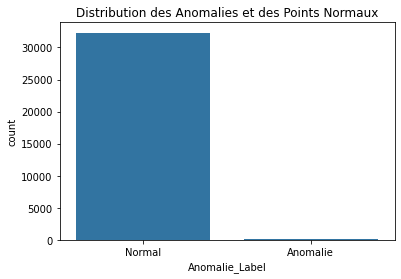

In [23]:
sns.countplot(x='Anomalie_Label', data=df_if)
plt.title("Distribution des Anomalies et des Points Normaux")
plt.show()

#### Some examples of easily separable data

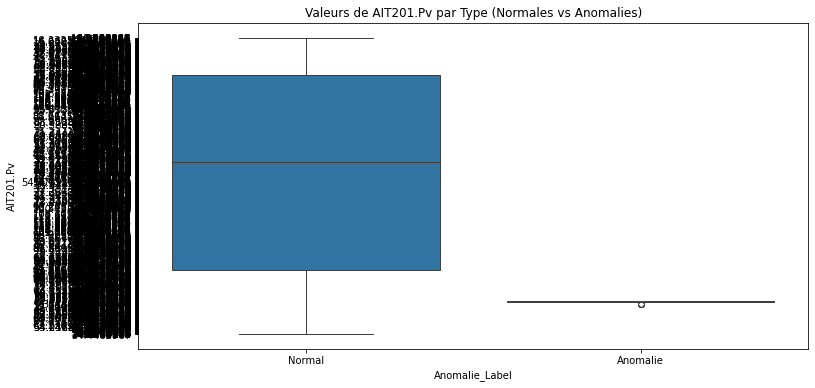

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='AIT201.Pv', data=df_if)
plt.title("Valeurs de AIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

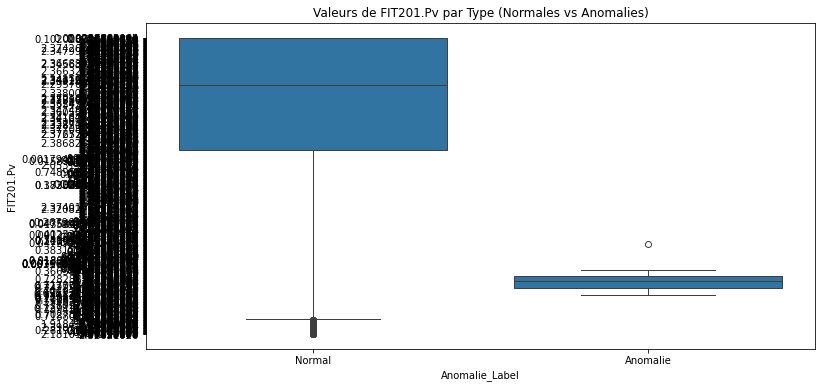

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='FIT201.Pv', data=df_if)
plt.title("Valeurs de FIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

df_if['PCA1'] = reduced_data[:, 0]
df_if['PCA2'] = reduced_data[:, 1]

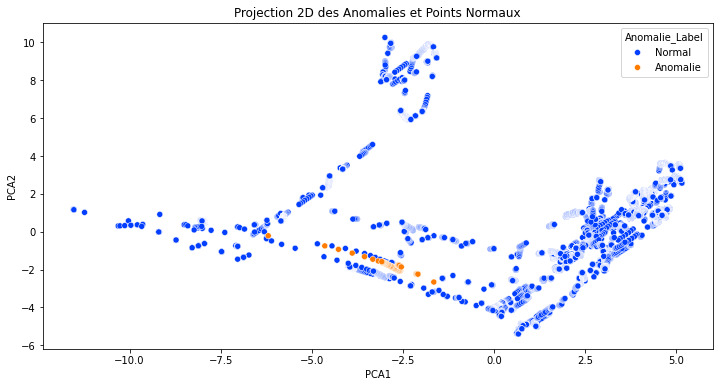

In [41]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Anomalie_Label', palette='bright', data=df_if)
plt.title("Projection 2D des Anomalies et Points Normaux")
plt.show()

### One Class SVM

In [56]:
svm = OneClassSVM(nu=0.02, kernel='rbf', gamma=0.001)
svm.fit(df_22_scaled)
df_29.loc[:, "Anomalie"] = svm.predict(df_29_scaled)
df_22.loc[:, "Anomalie"] = 1

df_svm = pd.concat([df_22, df_29], axis=0)
df_svm['Anomalie_Label'] = df_svm['Anomalie'].apply(lambda x: 'Normal' if x == 1 else 'Anomalie')
df_svm['Anomalie_Label'].value_counts()

Anomalie_Label
Normal      32179
Anomalie      222
Name: count, dtype: int64

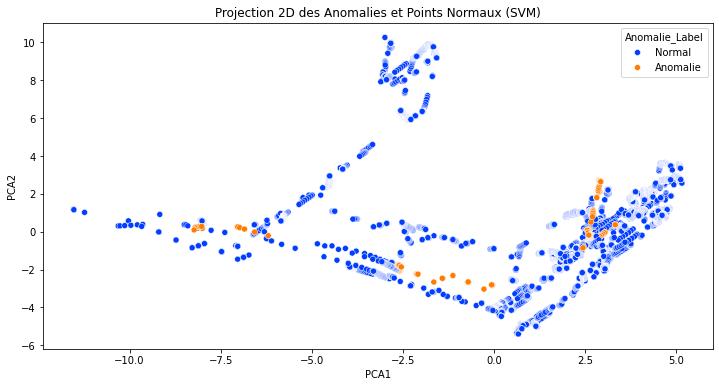

In [57]:
df_svm['PCA1'] = reduced_data[:, 0]
df_svm['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Anomalie_Label', palette='bright', data=df_svm)
plt.title("Projection 2D des Anomalies et Points Normaux (SVM)")
plt.show()

## option 2 : Adversarial attacks against classification

### Isolation Forest Anomalies

In [28]:
X = df_if.drop(columns=['Anomalie_Label'])
y = df_if['Anomalie_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

1.0


In [29]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Anomalie       1.00      1.00      1.00        31
      Normal       1.00      1.00      1.00      9690

    accuracy                           1.00      9721
   macro avg       1.00      1.00      1.00      9721
weighted avg       1.00      1.00      1.00      9721



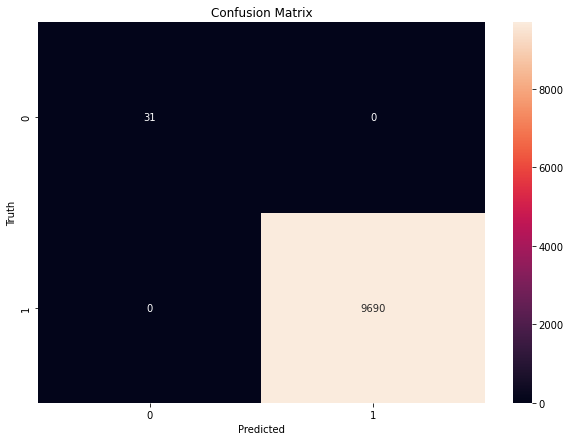

In [30]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

### One Class SVM Anomalies

In [58]:
X = df_svm.drop(columns=['Anomalie_Label'])
y = df_svm['Anomalie_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

1.0


In [59]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Anomalie       1.00      1.00      1.00        58
      Normal       1.00      1.00      1.00      9663

    accuracy                           1.00      9721
   macro avg       1.00      1.00      1.00      9721
weighted avg       1.00      1.00      1.00      9721



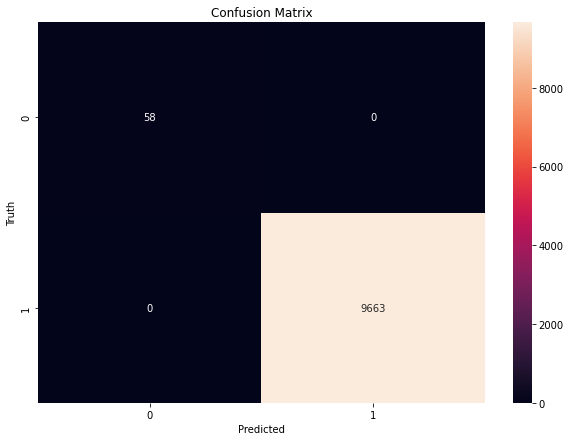

In [ ]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()